## 9 - Creating Motion Paths and Flowlines

In this notebook, we will show how GPlately's `PlateReconstruction` object:
- Creates a motion path of points to illustrate the trajectory of a tectonic plate through geological time, and
- Quantifies the rate of motion of a tectonic plate through time.

In [24]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import cartopy.crs as ccrs
import matplotlib
from matplotlib import image
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString
import geopandas as gpd

We use rotations from the WK08-A absolute plate motion model by Wessel and Kroenke (2008), which can be found in the Matthews et al. 2016 plate model. Let's request this model using the DataServer object with the string `Matthews2016`, and set up a `PlateReconstruction` object.

> Wessel, P., & Kroenke, L. W. (2008). Pacific absolute plate motion since 145 Ma: An assessment of the fixed hot spot hypothesis. Journal of Geophysical Research: Solid Earth, 113(B6). https://doi.org/10.1029/2007JB005499

Set up a `PlotTopologies` object for plotting.

In [25]:
# Request Matthews2016 from GPlately
gdownload = gplately.download.DataServer("Matthews2016")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Call the PlateReconstruction object to create a plate motion model
model = gplately.reconstruction.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Attempt to fetch Matthews et al. 2016 coastlines, continents and COBs from EarthByte servers
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Matthews2016.


### 1. The motion path of a Hawaiian-Emperor chain seed point
The latitude and longitude of a point representing present-day Hawaii is (19, -155) (in degrees). We model the point's trajectory as a hot spot trail (with `reconstruction_plate_ID` = 2) on the Pacific plate (with `relative_plate_ID` = 901) using `create_motion_path`, a function on the `PlateReconstruction` object. This 901-2 reconstruction ID pair is from Wessel and Kroenke's (2008) WK08-A model. 

#### Step plots of rates of motion
By setting `return_rate_of_motion` to `True` in `create_motion_path`, the function returns two additional ndarrays: one is a step time array, and another is a step-rate of plate motion array. Both are ready to plot.

In [26]:
# Latitude and longitude array (can have >1 lats and lons)
lats = np.array([19])
lons = np.array([-155])

# Plate IDs
plate_ID = 2
anchor_plate_ID = 901

# Create the time array for the motion path - must be float
start_reconstruction_time = 0.
time_step = 2.
max_reconstruction_time = 100.
time_array = np.arange(start_reconstruction_time, max_reconstruction_time + time_step, time_step)

# Get the latitudes and longitudes of all points along the motion path
lon, lat, step_times, step_rates_of_motion = model.create_motion_path(
    lons, lats, time_array, plate_ID, anchor_plate_ID, return_rate_of_motion=True)

Let's plot this motion path with the ETOPO1 global topology and bathymetry model. We can download this grid to the GPlately cache using DataServer:

In [27]:
etopo_tif_img = gdownload.get_raster("ETOPO1_tif")

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [28]:
# Creating the motion path and obtaining rate plot arrays using the gplately Points alternative
gpts = gplately.reconstruction.Points(model, lons, lats, time=0., plate_id=[plate_ID])
lon, lat, step_times, rates_of_motion = gpts.motion_path(
    time_array, 
    anchor_plate_ID, 
    return_rate_of_motion=True
)

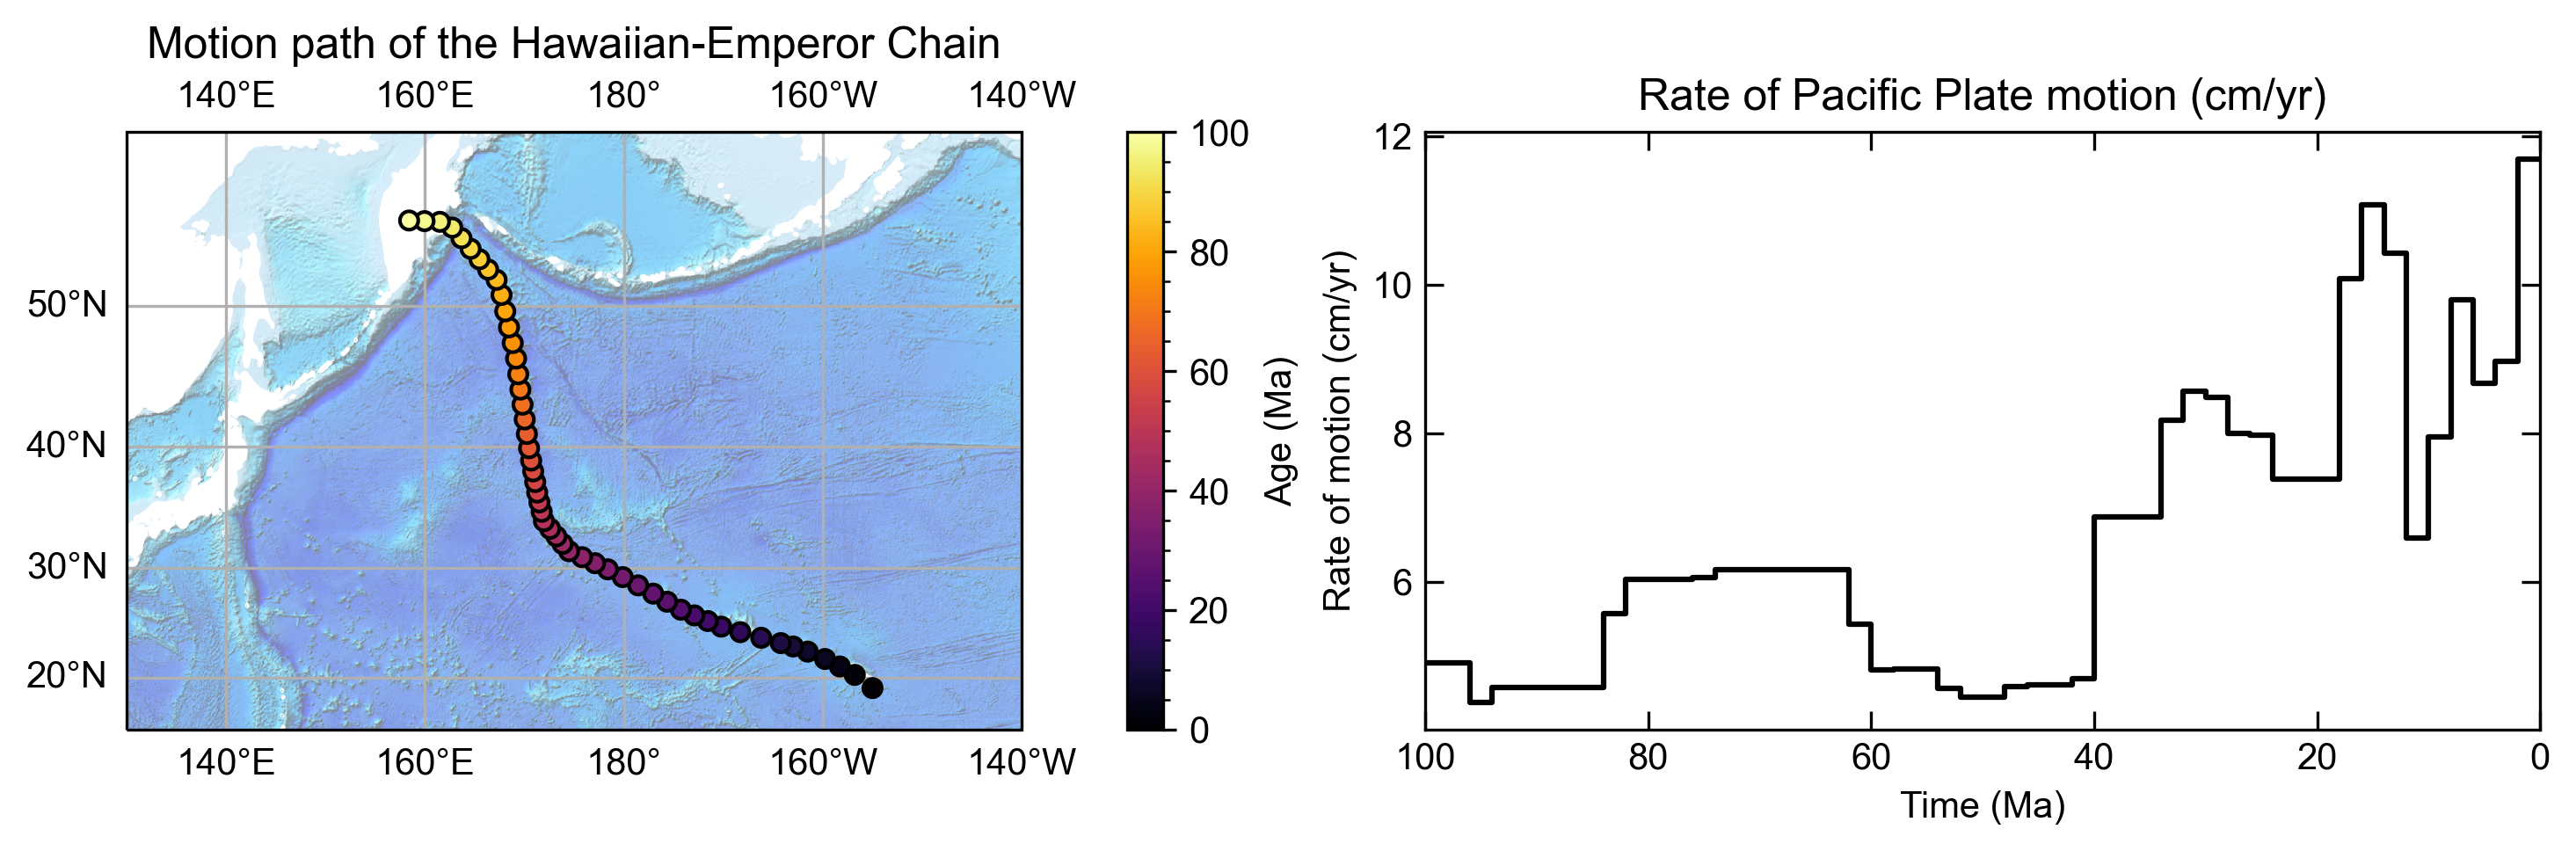

In [29]:
# --- Create figure
fig = plt.figure(figsize=(12, 3), dpi=300)
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(121, projection=ccrs.Mercator(central_longitude=180))
ax.set_title("Motion path of the Hawaiian-Emperor Chain")

# --- Limit map extent
lon_min = 130.
lon_max = 220  # if I specify as -150, it will plot as the 'other' way around the world
lat_min = 15.
lat_max = 60.
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, xlocs=np.arange(-180,180,20), ylocs=np.arange(-90,90,10))


# ---- Plot bathymetry
img_extent = (-180, 180, -90, 90)
ax.imshow(etopo_tif_img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.5,
          transform=ccrs.PlateCarree(central_longitude=0), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='white', zorder=2)

# --- Make sure motion path longitudes are wrapped correctly to the dateline
lon360 = gplately.tools.correct_longitudes_for_dateline(lon)

# --- plot motion path
ax.plot(lon360, lat, color='yellow', linewidth=0.75, transform=ccrs.PlateCarree(), zorder=3)
mp = ax.scatter(lon360, lat, 100, marker='.', c=time_array, cmap=plt.cm.inferno, edgecolor='k',
                transform=ccrs.PlateCarree(), vmin=time_array[0], vmax=time_array[-1], zorder=4)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(mp, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)')
cbar.ax.minorticks_on()

# --- Plot step times and step rates of motion on 2nd subplot
p = fig.add_subplot(122, xlabel='Time (Ma)', ylabel='Rate of motion (cm/yr)', xlim=[time_array.max(), 0])
p.set_title("Rate of Pacific Plate motion (cm/yr)")
p.tick_params(direction="in", length=5, top=True, right=True)
p.plot(step_times, rates_of_motion, color='k')

fig.savefig("Hawaii_Emperor_motion_path.pdf", bbox_inches='tight')

### 2. The motion path of several seed points 

Below, we model the motion of three seed points on the Indian craton (allocated plate ID 501) with respect to the Northern European craton (allocated anchor plate ID 301). The 501-301 rotation is derived through a plate circuit with the Matthews et al. 2016 model.

In [30]:
lats = np.array([30, 30, 30])
lons = np.array([73, 78, 83])

# Plate ID attributes
# motion of the Indian craton (501) with respect to the Northern European craton (301)
plate_ID = 501
anchor_plate_ID = 301 

# Create the time array for the motion path
start_reconstruction_time = 0.
time_step = 5.
max_reconstruction_time = 250.
time_array = np.arange(start_reconstruction_time, max_reconstruction_time + 1, time_step)

# Get the latitudes and longitudes of all points along the motion path
lon, lat, step_times, step_rates_of_motion = model.create_motion_path(
    lons, lats, time_array, plate_ID, anchor_plate_ID, 
    return_rate_of_motion=True)

We can also create a motion path using the `Points` object.

In [31]:
# gplately Points alternative
lats = np.array([30, 30, 30])
lons = np.array([73, 78, 83])

# Plate ID attributes
# motion of the Indian craton (501) with respect to the Northern European craton (301)
plate_ID = 501
anchor_plate_ID = 301 

# Call the Points object
gpts = gplately.reconstruction.Points(model, lons, lats, time=0., plate_id=[plate_ID, plate_ID, plate_ID])

# Create the time array for the motion path
start_reconstruction_time = 0.
time_step = 5.
max_reconstruction_time = 105.
time_array = np.arange(start_reconstruction_time, max_reconstruction_time + 1, time_step)

# Get the motion path and rate of motion (in step format) of these points
lon, lat, step_times, step_rates_of_motion = gpts.motion_path(
    time_array, 
    anchor_plate_ID, 
    return_rate_of_motion=True
)

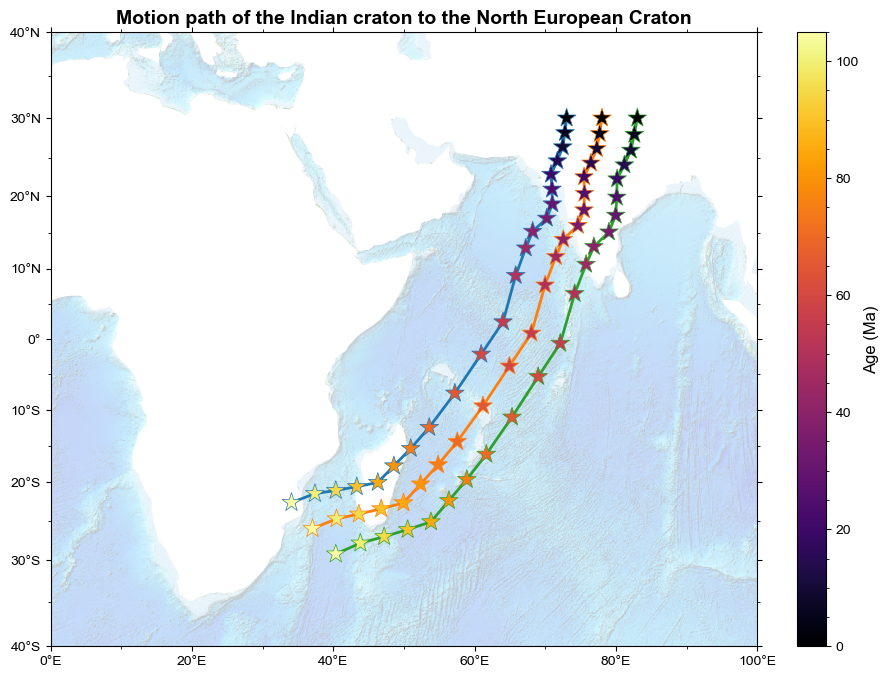

In [32]:
# --- Create figure
fig = plt.figure(figsize=(10,10), dpi=100)
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(111, projection=ccrs.Mercator(central_longitude=180))
ax.set_title("Motion path of the Indian craton to the North European Craton", fontsize=14, weight="demi")

# --- Plot tick labels
ax.set_xticks(np.arange(0, 360, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 100, 10), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(0, 360, 10), minor=True, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 5), minor=True, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.tick_bottom()  # labelled ticks on top
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('both')   # ticks on both top/bottom
ax.yaxis.set_ticks_position('both')   # ticks on both left/right

# --- Limit map extent
lon_min = 0.
lon_max = 100 
lat_min = -40.
lat_max = 40.
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# ---- Plot bathymetry
img_extent = (-180, 180, -90, 90)
ax.imshow(etopo_tif_img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.25,
          transform=ccrs.PlateCarree(central_longitude=0), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='white', zorder=2)

# --- Make sure negtive motion path longitudes are wrapped correctly to the dateline
lons = gplately.tools.correct_longitudes_for_dateline(lons)

# --- plot motion path
colors = ['c0', 'c1', 'c2']
for i in np.arange(0,len(lons)):
    ax.plot(lon[:,i], lat[:,i], color="C{}".format(i), linewidth=2, transform=ccrs.PlateCarree(), zorder=3)
    mp = ax.scatter(lon[:,i], lat[:,i], 200, marker='*', c=time_array, cmap=plt.cm.inferno, edgecolor="C{}".format(i),
                    linewidth=0.5, transform=ccrs.PlateCarree(), vmin=time_array[0], vmax=time_array[-1], zorder=4)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(mp, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)', fontsize=12)
cbar.ax.minorticks_on()

plt.show()

### Rates of motion

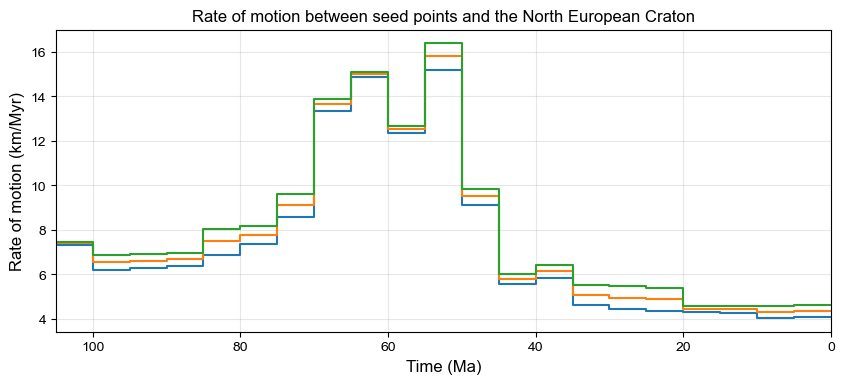

In [33]:
fig = plt.figure(figsize=(10,4), dpi=100)
plt.title("Rate of motion between seed points and the North European Craton")
plt.plot(step_times, step_rates_of_motion)
plt.xlabel('Time (Ma)', fontsize=12)
plt.ylabel('Rate of motion (km/Myr)', fontsize=12)
plt.gca().invert_xaxis()
plt.xlim([max_reconstruction_time, 0])
plt.grid(alpha=0.3)
plt.show()

### 2. Flowlines from a mid-ocean ridge in the South Atlantic
A flowline is a series of point locations reconstructed through time to track the motion of tectonic plates from spreading features like mid-ocean ridges. 

We can generate one or more flowlines with `create_flowline` from GPlately's `PlateReconstruction` object. All we need is an array of latitudes and longitudes of points along a mid-ocean ridge, the IDs of the plate to the left and right of the mid-ocean ridge, and an array of reconstruction times.

In [34]:
# Longitudes and latitudes of points along the South Atlantic mid ocean ridge
lons = np.array([-15.4795, -14.9688, -14.0632, -17.7739])
lats = np.array([-1.60584,-11.9764, -25.7209, -35.7228])

# Left and right plate IDs
left_plate_ID = 201
right_plate_ID = 701

# Constructing the time array
time_step = 5.
max_reconstruction_time = 120
time_array = np.arange(0, max_reconstruction_time+time_step, time_step)

# Generate the latitudes and longitude coordinates of the flowlines to the left and right of the MOR!
left_lon, left_lat, right_lon, right_lat, steptime, steprate = model.create_flowline(
    lons,
    lats,
    time_array,
    left_plate_ID,
    right_plate_ID,
    return_rate_of_motion=True
)

Let's illustrate these flowlines with mid-ocean ridge/transform boundaries from Seton et al. (2012) using the `PlotTopologies` object.

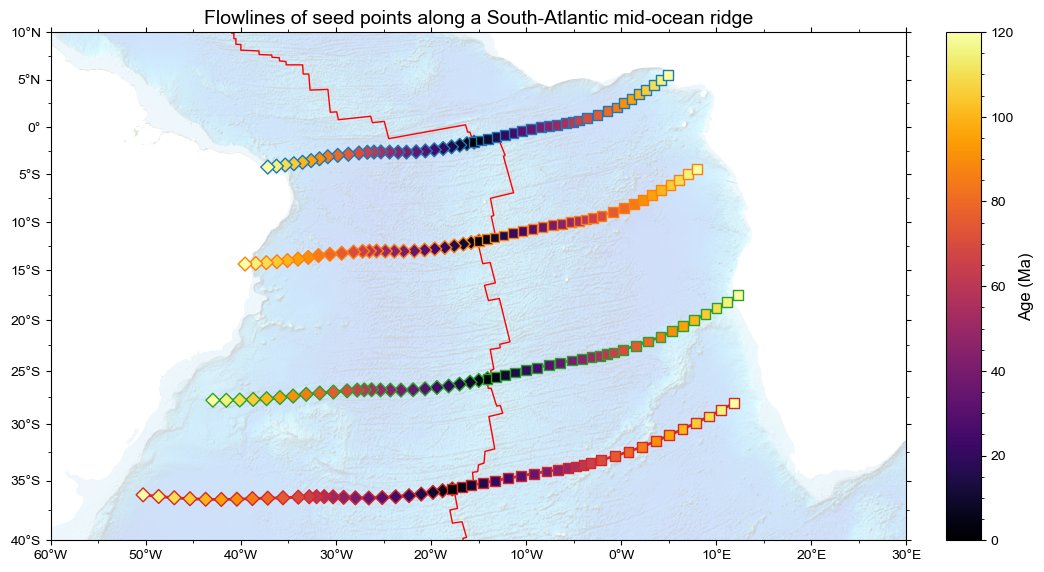

In [35]:
# --- Create figure
fig = plt.figure(figsize=(12, 12), dpi=100)
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_title("Flowlines of seed points along a South-Atlantic mid-ocean ridge", fontsize=14)

# --- Plot tick labels. This doesn't work for all projections in cartopy yet...
ax.set_xticks(np.arange(-180, 190, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 95, 5), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-180, 185, 5), minor=True, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 2.5), minor=True, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.tick_bottom()  # labelled ticks on top
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('both')   # ticks on both top/bottom
ax.yaxis.set_ticks_position('both')   # ticks on both left/right

# --- Limit map extent
lon_min = -60
lon_max = 30
lat_min = -40.
lat_max = 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# ---- Plot bathymetry
ax.imshow(etopo_tif_img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.2,
          transform=ccrs.PlateCarree(), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='white', zorder=2)
gplot.plot_ridges_and_transforms(ax, color="r", linewidth=1)

# --- Make sure flowline longitudes are wrapped correctly to the dateline
#left_lon = gplately.tools.correct_longitudes_for_dateline(left_lon)
#right_lon = gplately.tools.correct_longitudes_for_dateline(right_lon)

# --- Iterate over the reconstructed flowlines. Each seed point results in a 'left' and 'right' flowline 
for i in np.arange(0,len(lons)):
     
    # plot left flowlines as circles
    ax.plot(left_lon[:,i], left_lat[:,i], color="C{}".format(i), linewidth=2, transform=ccrs.PlateCarree(), zorder=3)
    fl = ax.scatter(left_lon[:,i], left_lat[:,i], s=50, marker='D', c=time_array,
                    transform=ccrs.PlateCarree(), cmap=plt.cm.inferno, edgecolor="C{}".format(i),
                    vmin=time_array[0], vmax=time_array[-1], zorder=4)
    
    # plot right flowlines as stars
    ax.plot(right_lon[:,i], right_lat[:,i], color="C{}".format(i), linewidth=2, transform=ccrs.PlateCarree(), zorder=3)
    ax.scatter(right_lon[:,i], right_lat[:,i], s=50, marker='s', c=time_array,
               transform=ccrs.PlateCarree(), cmap=plt.cm.inferno, edgecolor="C{}".format(i),
               vmin=time_array[0], vmax=time_array[-1], zorder=4)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(fl, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)', fontsize=12)
cbar.ax.minorticks_on()

fig.savefig("Flowlines_South_Atlantic.pdf", bbox_inches='tight')

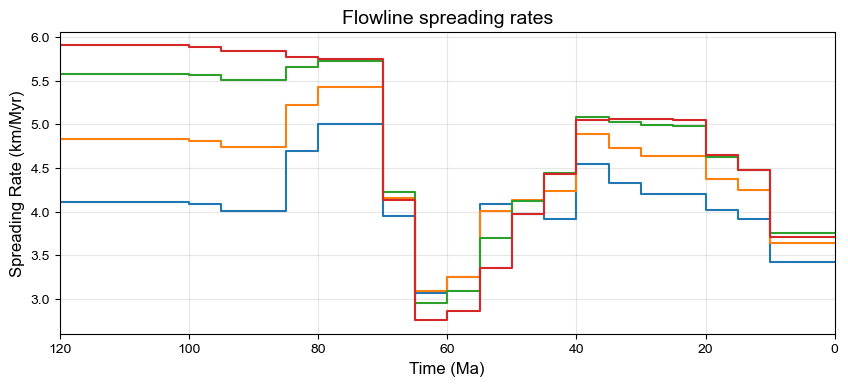

In [13]:
fig = plt.figure(figsize=(10,4), dpi=100)

plt.plot(steptime, steprate)
plt.title("Flowline spreading rates", fontsize=14)
plt.xlabel('Time (Ma)', fontsize=12)
plt.ylabel('Spreading Rate (km/Myr)', fontsize=12)
plt.gca().invert_xaxis()
plt.xlim([max_reconstruction_time, 0])
plt.grid(alpha=0.3)
plt.show()